## Librerias

In [52]:
library(dplyr)
library(ggplot2)
library(MASS)
library(car)
library(broom)
library(hnp)

## Data

In [53]:
data <- read.csv("../data/processed/tabla_severidad.csv")
data$X <- NULL

In [54]:
head(data)

,Modelo,Color,Carroceria,CLASE_FASECOLDA,TIPO_VEHICULO,SERVICIO,Sexo_Aseg,Edad,Gama,n_siniestros,exposicion_total,suma_pagos,n_observaciones,severidad_media
,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<int>,<dbl>,<dbl>,<int>,<dbl>
1,1993_1999,BLANCO,SEDAN,AUTOMOVIL,Livianos,Particular,F,19_41,Baja,2,6.602740,8014069,13,4007034.6
2,1993_1999,BLANCO,SEDAN,AUTOMOVIL,Livianos,Particular,F,41_63,Baja,2,10.580822,2204046,22,1102023.2
3,1993_1999,BLANCO,SEDAN,AUTOMOVIL,Livianos,Particular,M,19_41,Baja,4,11.569863,6450375,23,1612593.7
4,1993_1999,BLANCO,SEDAN,AUTOMOVIL,Livianos,Particular,M,41_63,Baja,2,8.430137,4238816,16,2119408.0
5,1993_1999,Otros,Otros,CAMIONETA,Livianos,Particular,F,41_63,Baja,2,3.010959,1208679,6,604339.6
6,1993_1999,Otros,SEDAN,AUTOMOVIL,Livianos,Particular,F,19_41,Baja,2,16.800000,8213167,35,4106583.6


In [55]:
summary(data$suma_pagos)

    Min.  1st Qu.   Median     Mean  3rd Qu.     Max. 
  114915  2786327  5713529 10953300 12093608 85923693 

## Seleccion de variables

In [56]:
establecer_categorias_referencia <- function(df, vars_categoricas, var_exposicion = "exposicion_total") {
  df_copy <- df
  
  for (var in vars_categoricas) {
    exposicion_por_categoria <- aggregate(df_copy[[var_exposicion]], 
                                        by = list(df_copy[[var]]), 
                                        FUN = sum, na.rm = TRUE)
    names(exposicion_por_categoria) <- c("categoria", "exposicion_total")
    
    categoria_referencia <- exposicion_por_categoria$categoria[which.max(exposicion_por_categoria$exposicion_total)]
    
    cat("Variable:", var, "- Categoría de referencia:", categoria_referencia, "\n")
    
    df_copy[[var]] <- factor(df_copy[[var]])
    df_copy[[var]] <- relevel(df_copy[[var]], ref = as.character(categoria_referencia))
  }
  
  return(df_copy)
}

vars_categoricas <- c("Modelo", "Color", "Carroceria", "CLASE_FASECOLDA", 
                     "TIPO_VEHICULO", "SERVICIO", "Sexo_Aseg", "Edad", "Gama")

data <- establecer_categorias_referencia(data, vars_categoricas)

str(data)

Variable: Modelo - Categoría de referencia: 2007_2013 
Variable: Color - Categoría de referencia: Otros 
Variable: Carroceria - Categoría de referencia: SEDAN 
Variable: CLASE_FASECOLDA - Categoría de referencia: AUTOMOVIL 
Variable: TIPO_VEHICULO - Categoría de referencia: Livianos 
Variable: SERVICIO - Categoría de referencia: Particular 
Variable: Sexo_Aseg - Categoría de referencia: M 
Variable: Edad - Categoría de referencia: 41_63 
Variable: Gama - Categoría de referencia: Media 
'data.frame':	229 obs. of  14 variables:
 $ Modelo          : Factor w/ 3 levels "2007_2013","1993_1999",..: 2 2 2 2 2 2 2 2 2 2 ...
 $ Color           : Factor w/ 4 levels "Otros","AMARILLO",..: 3 3 3 3 1 1 1 1 1 1 ...
 $ Carroceria      : Factor w/ 4 levels "SEDAN","CABINADO",..: 1 1 1 1 4 1 1 1 1 1 ...
 $ CLASE_FASECOLDA : Factor w/ 4 levels "AUTOMOVIL","AUTOMOVIL TAXI",..: 1 1 1 1 3 1 1 1 1 1 ...
 $ TIPO_VEHICULO   : Factor w/ 2 levels "Livianos","Pesados": 1 1 1 1 1 1 1 1 1 1 ...
 $ SERVICIO        

## Quasi-Poisson

In [57]:
modelo_inicial <- glm(
  n_siniestros ~ Modelo + Color + Carroceria + CLASE_FASECOLDA + 
                 TIPO_VEHICULO + SERVICIO + Sexo_Aseg + Edad + 
                 offset(log(exposicion_total)),
  family = poisson,
  data = data
)

modelo_nulo <- glm(
  n_siniestros ~ 1,
  family = poisson,
  data = data
)

modelo_stepwise <- step(modelo_inicial, direction = "forward", trace = FALSE)
modelo_frecuencia_qp <- update(modelo_stepwise, family = quasipoisson)
summary(modelo_frecuencia_qp)


Call:
glm(formula = n_siniestros ~ Modelo + Color + Carroceria + CLASE_FASECOLDA + 
    TIPO_VEHICULO + SERVICIO + Sexo_Aseg + Edad + offset(log(exposicion_total)), 
    family = quasipoisson, data = data)

Deviance Residuals: 
    Min       1Q   Median       3Q      Max  
-2.7769  -0.4191   0.2035   0.7014   1.8524  

Coefficients:
                              Estimate Std. Error t value Pr(>|t|)    
(Intercept)                   -1.63521    0.08326 -19.640  < 2e-16 ***
Modelo1993_1999                0.14159    0.18568   0.763  0.44659    
Modelo2000_2006                0.30113    0.09219   3.266  0.00127 ** 
ColorAMARILLO                  0.31279    0.39828   0.785  0.43314    
ColorBLANCO                    0.10404    0.10500   0.991  0.32291    
ColorPLATA                     0.12814    0.08715   1.470  0.14297    
CarroceriaCABINADO             0.17481    0.22410   0.780  0.43624    
CarroceriaHATCHBACK            0.10622    0.07689   1.381  0.16864    
CarroceriaOtros          

## Modelo simplificado

In [58]:
modelo_frecuencia_qp <- glm(
  n_siniestros ~ Modelo + Edad + offset(log(exposicion_total)),
  family = quasipoisson,
  data = data
)

## Evaluación

In [59]:
dispersion <- sum(residuals(modelo_frecuencia_qp, type = "pearson")^2) / modelo_frecuencia_qp$df.residual
cat("Parámetro de dispersión:", dispersion, "\n")

Parámetro de dispersión: 0.9423814 


pdf 
  2

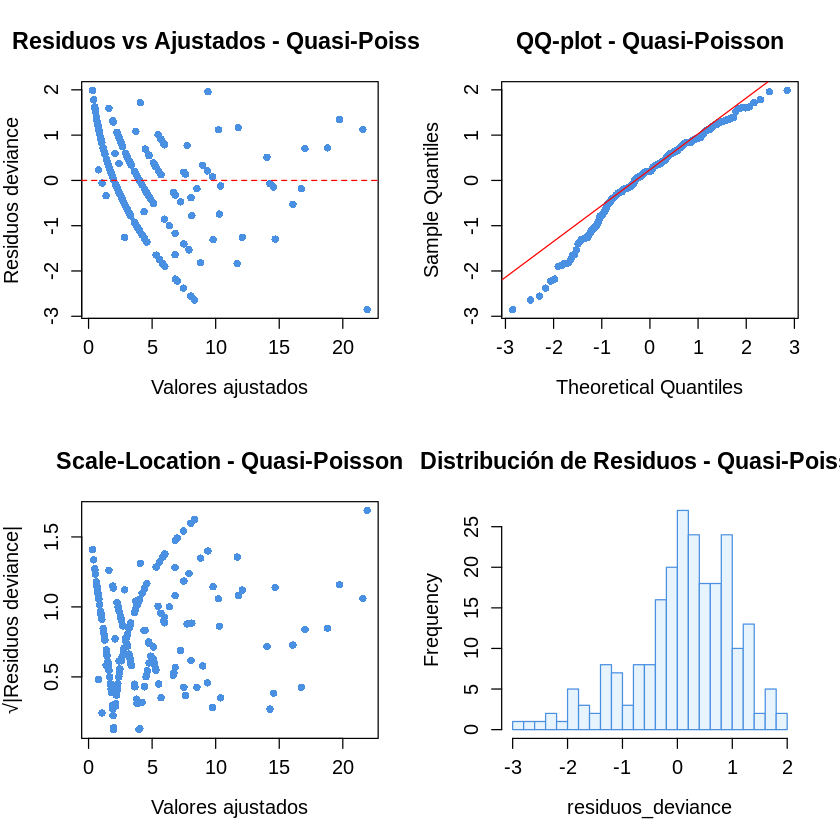

In [60]:
# Gráficos diagnósticos para el modelo quasi-poisson
residuos_deviance <- residuals(modelo_frecuencia_qp, type = "deviance")
valores_ajustados <- fitted(modelo_frecuencia_qp)

# Guardar en images/
png("../images/diagnosticos_frecuencia_quasipoisson.png", width = 1000, height = 800, res = 120)
par(mfrow = c(2, 2), cex.axis = 1.4, cex.lab = 1.4, cex.main = 1.6)

plot(valores_ajustados, residuos_deviance,
     xlab = "Valores ajustados", 
     ylab = "Residuos deviance",
     main = "Residuos vs Ajustados - Quasi-Poisson",
     pch = 16, col = "#4A90E2", cex = 1.2)
abline(h = 0, col = "red", lty = 2, lwd = 2)

qqnorm(residuos_deviance, main = "QQ-plot - Quasi-Poisson", pch = 16, col = "#4A90E2", cex = 1.2)
qqline(residuos_deviance, col = "red", lwd = 2)

plot(valores_ajustados, sqrt(abs(residuos_deviance)),
     xlab = "Valores ajustados",
     ylab = "√|Residuos deviance|",
     main = "Scale-Location - Quasi-Poisson",
     pch = 16, col = "#4A90E2", cex = 1.2)

hist(residuos_deviance, breaks = 30, main = "Distribución de Residuos - Quasi-Poisson",
     xlab = "Residuos deviance",
     col = "#E8F4FD", border = "#4A90E2")

dev.off()

# Mostrar también en el notebook
par(mfrow = c(2, 2), cex.axis = 1.2, cex.lab = 1.2, cex.main = 1.4)

plot(valores_ajustados, residuos_deviance,
     xlab = "Valores ajustados", 
     ylab = "Residuos deviance",
     main = "Residuos vs Ajustados - Quasi-Poisson",
     pch = 16, col = "#4A90E2")
abline(h = 0, col = "red", lty = 2)

qqnorm(residuos_deviance, main = "QQ-plot - Quasi-Poisson", pch = 16, col = "#4A90E2")
qqline(residuos_deviance, col = "red")

plot(valores_ajustados, sqrt(abs(residuos_deviance)),
     xlab = "Valores ajustados",
     ylab = "√|Residuos deviance|",
     main = "Scale-Location - Quasi-Poisson",
     pch = 16, col = "#4A90E2")

hist(residuos_deviance, breaks = 30, main = "Distribución de Residuos - Quasi-Poisson",
     col = "#E8F4FD", border = "#4A90E2")

par(mfrow = c(1, 1))

Quasi-Poisson model 
Total points: 229 
Points out of envelope: 95 ( 41.48 %) 


pdf 
  2

Quasi-Poisson model 


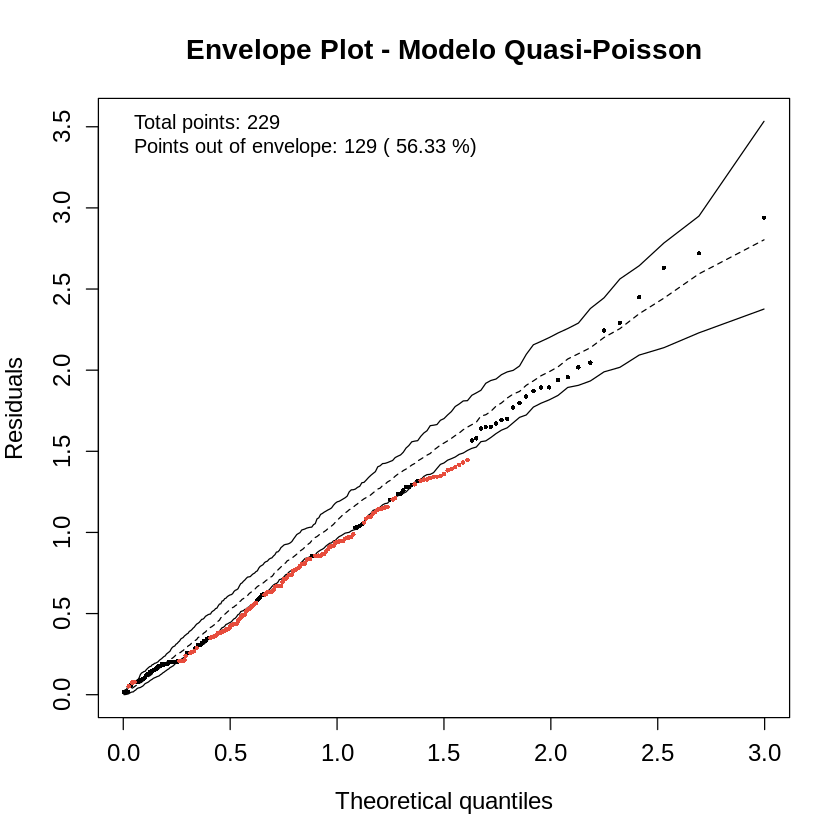

In [61]:
# Envelope plot para modelo quasi-poisson
set.seed(1)

# Guardar en images/
png("../images/envelope_frecuencia_quasipoisson.png", width = 700, height = 700, res = 120)
par(cex.axis = 1.4, cex.lab = 1.4, cex.main = 1.6)
envelope_qp <- hnp(modelo_frecuencia_qp, sim = 99, conf = 0.95, halfnormal = TRUE, 
    scale = TRUE, plot.sim = TRUE, how.many.out = TRUE, 
    print.on = FALSE, paint.out = TRUE, 
    main = "Envelope Plot - Modelo Quasi-Poisson",
    col.paint.out = "#E74C3C", pch = 16, cex = 1.2)
dev.off()

# Mostrar también en el notebook
par(cex.axis = 1.2, cex.lab = 1.2, cex.main = 1.4)
envelope_qp <- hnp(modelo_frecuencia_qp, sim = 99, conf = 0.95, halfnormal = TRUE, 
    scale = TRUE, plot.sim = TRUE, how.many.out = TRUE, 
    print.on = TRUE, paint.out = TRUE, 
    main = "Envelope Plot - Modelo Quasi-Poisson",
    col.paint.out = "#E74C3C", pch = 16)

## Binomial Negativa

In [62]:
modelo_inicial <- glm.nb(
  n_siniestros ~ Modelo + Color + Carroceria + CLASE_FASECOLDA + 
                 TIPO_VEHICULO + SERVICIO + Sexo_Aseg + Edad + 
                 offset(log(exposicion_total)),
  data = data
)

modelo_stepwise <- step(modelo_inicial, direction = "forward", trace = FALSE)
modelo_frecuencia_nb <- update(modelo_stepwise)
summary(modelo_frecuencia_nb)


Call:
glm.nb(formula = n_siniestros ~ Modelo + Color + Carroceria + 
    CLASE_FASECOLDA + TIPO_VEHICULO + SERVICIO + Sexo_Aseg + 
    Edad + offset(log(exposicion_total)), data = data, init.theta = 7958.115017, 
    link = log)

Deviance Residuals: 
    Min       1Q   Median       3Q      Max  
-2.7744  -0.4190   0.2032   0.7010   1.8509  

Coefficients:
                              Estimate Std. Error z value Pr(>|z|)    
(Intercept)                   -1.63522    0.08719 -18.754  < 2e-16 ***
Modelo1993_1999                0.14161    0.19440   0.728  0.46634    
Modelo2000_2006                0.30119    0.09653   3.120  0.00181 ** 
ColorAMARILLO                  0.31316    0.41694   0.751  0.45260    
ColorBLANCO                    0.10407    0.10993   0.947  0.34381    
ColorPLATA                     0.12816    0.09125   1.404  0.16018    
CarroceriaCABINADO             0.17479    0.23461   0.745  0.45627    
CarroceriaHATCHBACK            0.10627    0.08052   1.320  0.18690    
Ca

In [63]:
modelo_frecuencia_bn <- glm.nb(
  n_siniestros ~ Modelo + Edad + offset(log(exposicion_total)),
  data = data
)

In [64]:
# Verificar sobredispersión
dispersion <- sum(residuals(modelo_frecuencia_bn, type = "pearson")^2) / modelo_frecuencia_bn$df.residual
cat("Parámetro de dispersión:", dispersion, "\n")

if (dispersion > 1.5) {
  cat("ADVERTENCIA: Hay evidencia de sobredispersión. Considerar modelo quasi-Poisson o binomial negativa.\n")
} else {
  cat("La dispersión parece apropiada para el modelo Poisson.\n")
}

Parámetro de dispersión: 0.9311384 
La dispersión parece apropiada para el modelo Poisson.


pdf 
  2

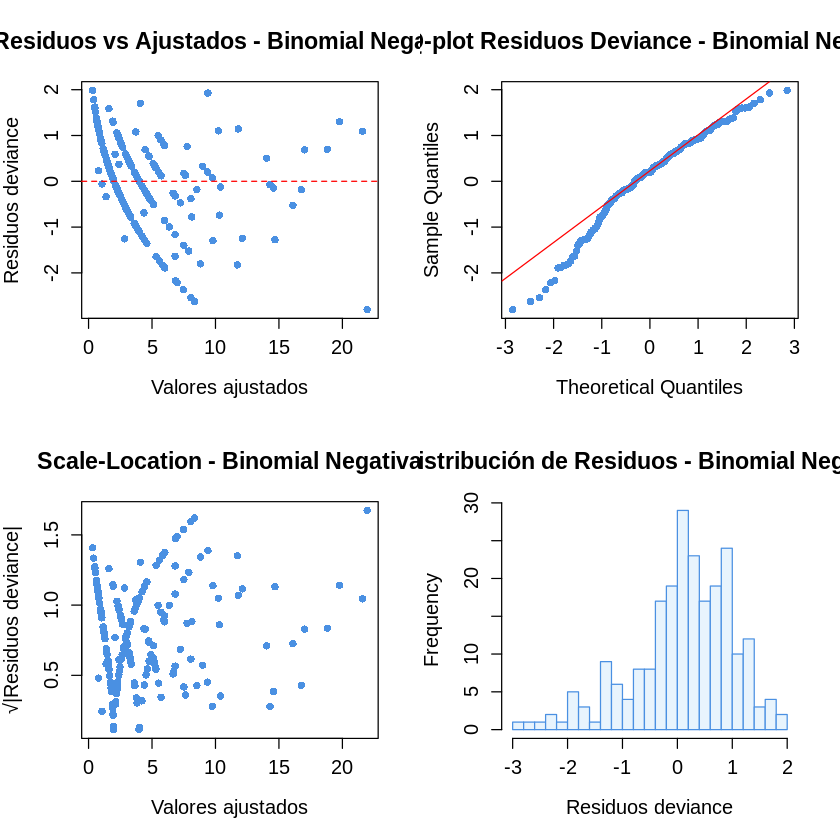

In [65]:
# Gráficos diagnósticos para el modelo binomial negativa
residuos_deviance <- residuals(modelo_frecuencia_bn, type = "deviance")
residuos_pearson <- residuals(modelo_frecuencia_bn, type = "pearson")
valores_ajustados <- fitted(modelo_frecuencia_bn)

# Guardar panel de diagnósticos en images/
png("../images/diagnosticos_frecuencia_binomial_negativa.png", width = 1000, height = 800, res = 120)
par(mfrow = c(2, 2), cex.axis = 1.4, cex.lab = 1.4, cex.main = 1.6)

# Residuos vs valores ajustados
plot(valores_ajustados, residuos_deviance,
     xlab = "Valores ajustados", 
     ylab = "Residuos deviance",
     main = "Residuos vs Ajustados - Binomial Negativa",
     pch = 16, col = "#4A90E2", cex = 1.2)
abline(h = 0, col = "red", lty = 2, lwd = 2)

# QQ-plot de residuos
qqnorm(residuos_deviance, 
       main = "QQ-plot Residuos Deviance - Binomial Negativa",
       pch = 16, col = "#4A90E2", cex = 1.2)
qqline(residuos_deviance, col = "red", lwd = 2)

# Scale-Location
plot(valores_ajustados, sqrt(abs(residuos_deviance)),
     xlab = "Valores ajustados",
     ylab = "√|Residuos deviance|",
     main = "Scale-Location - Binomial Negativa",
     pch = 16, col = "#4A90E2", cex = 1.2)

# Histograma de residuos
hist(residuos_deviance, 
     breaks = 30,
     main = "Distribución de Residuos - Binomial Negativa",
     xlab = "Residuos deviance",
     col = "#E8F4FD",
     border = "#4A90E2")

dev.off()

# Mostrar también en el notebook
par(mfrow = c(2, 2), cex.axis = 1.2, cex.lab = 1.2, cex.main = 1.4)

plot(valores_ajustados, residuos_deviance,
     xlab = "Valores ajustados", 
     ylab = "Residuos deviance",
     main = "Residuos vs Ajustados - Binomial Negativa",
     pch = 16, col = "#4A90E2")
abline(h = 0, col = "red", lty = 2)

qqnorm(residuos_deviance, 
       main = "QQ-plot Residuos Deviance - Binomial Negativa",
       pch = 16, col = "#4A90E2")
qqline(residuos_deviance, col = "red")

plot(valores_ajustados, sqrt(abs(residuos_deviance)),
     xlab = "Valores ajustados",
     ylab = "√|Residuos deviance|",
     main = "Scale-Location - Binomial Negativa",
     pch = 16, col = "#4A90E2")

hist(residuos_deviance, 
     breaks = 30,
     main = "Distribución de Residuos - Binomial Negativa",
     xlab = "Residuos deviance",
     col = "#E8F4FD",
     border = "#4A90E2")

par(mfrow = c(1, 1))

Negative binomial model (using MASS package) 
Total points: 229 
Points out of envelope: 137 ( 59.83 %) 


pdf 
  2

Negative binomial model (using MASS package) 


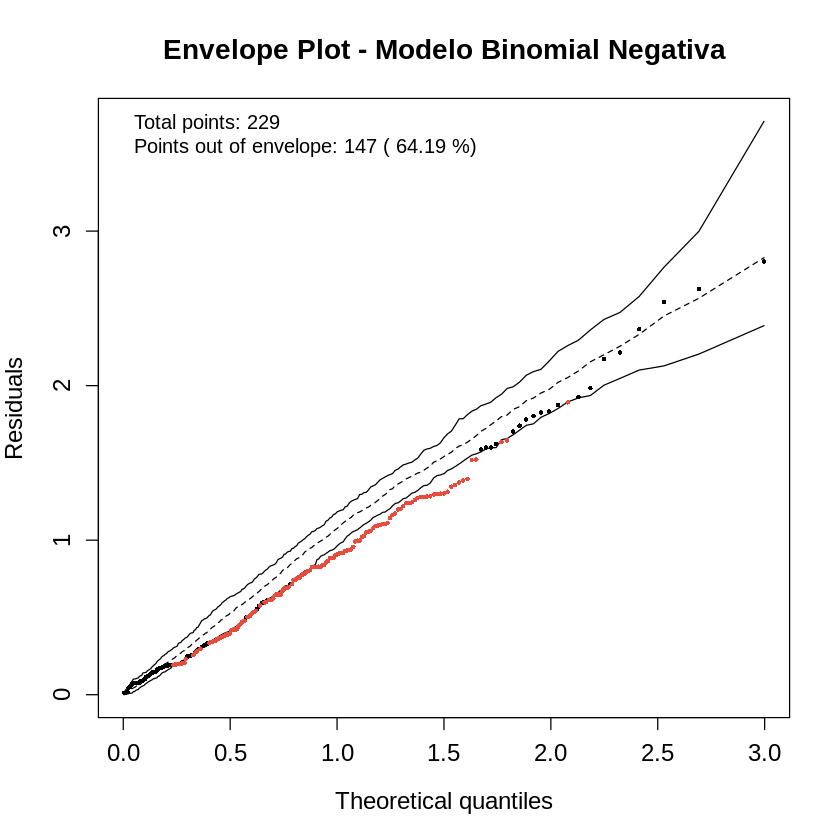

In [66]:
# Envelope plot para modelo binomial negativa
set.seed(123)

# Guardar envelope plot en images/
png("../images/envelope_frecuencia_binomial_negativa.png", width = 700, height = 700, res = 120)
par(cex.axis = 1.4, cex.lab = 1.4, cex.main = 1.6)
envelope_frecuencia <- hnp(modelo_frecuencia_bn, 
                     sim = 99,           # Número de simulaciones
                     conf = 0.95,        # Nivel de confianza
                     halfnormal = TRUE,  # Gráfico half-normal
                     scale = TRUE,       # Escalar residuos
                     plot.sim = TRUE,    # Mostrar simulaciones
                     verb.sim = FALSE,   # Sin output verbose
                     how.many.out = TRUE,# Contar outliers
                     print.on = FALSE,   # Sin estadísticas en consola
                     paint.out = TRUE,   # Colorear outliers
                     main = "Envelope Plot - Modelo Binomial Negativa",
                     col.paint.out = "#E74C3C",
                     pch = 16,
                     cex = 1.2)
dev.off()

# Mostrar también en el notebook
par(cex.axis = 1.2, cex.lab = 1.2, cex.main = 1.4)
envelope_frecuencia <- hnp(modelo_frecuencia_bn, 
                     sim = 99,           
                     conf = 0.95,        
                     halfnormal = TRUE,  
                     scale = TRUE,       
                     plot.sim = TRUE,    
                     verb.sim = FALSE,   
                     how.many.out = TRUE,
                     print.on = TRUE,    
                     paint.out = TRUE,   
                     main = "Envelope Plot - Modelo Binomial Negativa",
                     col.paint.out = "#E74C3C",
                     pch = 16)

## Exportar Modelos

In [67]:
saveRDS(modelo_frecuencia_qp, file = "../models/modelo_frecuencia_quasipoisson.rds")

modelo_frecuencia_info <- list(
  modelo = modelo_frecuencia_qp,
  aic = AIC(modelo_frecuencia_qp),
  formula = formula(modelo_frecuencia_qp),
  family = "Quasi-Poisson",
  dispersion = summary(modelo_frecuencia_qp)$dispersion,
  fecha_entrenamiento = Sys.Date()
)

saveRDS(modelo_frecuencia_info, file = "../models/modelo_frecuencia_quasipoisson_completo.rds")